In [1]:
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np


Importing Dataset:

In [2]:
anime_info_df= pd.read_csv('./anime.csv')
user_rating_df= pd.read_csv('./rating.csv')


In [3]:
anime_info_df.info()
print("\n")
user_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


Hmm, in anime_info_df why is episodes column data type of object it should be int/float. As the column suggets the number of episodes in that anime. This may be case when there are values with more than one data type we need to take a closer look what mischief does this column contains. 

In data frame user_rating_df rating column is of data type int. Although ratings are give in scale of 0 to 10. Let's change it to float as time may come when we need to aggregate this column. 
Let's change the column name of rating to user_rating to avoid confusion if we merget these two dataframe


In [4]:
print("Number of unique values in episodes columns:", anime_info_df["episodes"].nunique())
anime_info_df["episodes"].unique()

Number of unique values in episodes columns: 187


array(['1', '64', '51', '24', '10', '148', '110', '13', '201', '25', '22',
       '75', '4', '26', '12', '27', '43', '74', '37', '2', '11', '99',
       'Unknown', '39', '101', '47', '50', '62', '33', '112', '23', '3',
       '94', '6', '8', '14', '7', '40', '15', '203', '77', '291', '120',
       '102', '96', '38', '79', '175', '103', '70', '153', '45', '5',
       '21', '63', '52', '28', '145', '36', '69', '60', '178', '114',
       '35', '61', '34', '109', '20', '9', '49', '366', '97', '48', '78',
       '358', '155', '104', '113', '54', '167', '161', '42', '142', '31',
       '373', '220', '46', '195', '17', '1787', '73', '147', '127', '16',
       '19', '98', '150', '76', '53', '124', '29', '115', '224', '44',
       '58', '93', '154', '92', '67', '172', '86', '30', '276', '59',
       '72', '330', '41', '105', '128', '137', '56', '55', '65', '243',
       '193', '18', '191', '180', '91', '192', '66', '182', '32', '164',
       '100', '296', '694', '95', '68', '117', '151', '130',

Oh! I see why episode dataframe is of datatype object. Unknown is the culprit here. Luckily I found just the right function to change Unknown to NAN and other number as string to float.

In [5]:
anime_info_df["episodes"]=pd.to_numeric(anime_info_df["episodes"],errors='coerce')
print("Number of unique values in episodes columns:", anime_info_df["episodes"].nunique())
print("Data type of episode column:",anime_info_df["episodes"].dtype)

Number of unique values in episodes columns: 186
Data type of episode column: float64


In [6]:
user_rating_df.rename(columns={"rating":"user_rating"},inplace=True)
user_rating_df["user_rating"]=user_rating_df["user_rating"].astype(float)

# Duplicates

In [7]:
print(f"Number of duplicate rows in user_rating_df : {user_rating_df.duplicated().sum()}")
print(f"Number of duplicate rows in anime_info_df : {anime_info_df.duplicated().sum()}")

Number of duplicate rows in user_rating_df : 1
Number of duplicate rows in anime_info_df : 0


Well it doesn't hurt to make sure if there are duplicate animes with different features. So Let's see if there are duplicate anime_id in anime_info_df

In [8]:
print(f"Number of duplicate anime_ids: {anime_info_df.anime_id.duplicated().sum()}")

Number of duplicate anime_ids: 0


phew, that's a good start

Now Just to be sure let's check if a user gave rating to same anime multiple times.

In [9]:
duplicate_df=user_rating_df[user_rating_df.duplicated(subset=['user_id', 'anime_id'], keep=False)].sort_values("anime_id")
duplicate_df

,user_id,anime_id,user_rating
4499243,42653,1575,8.0
4499286,42653,1575,6.0
4499244,42653,2001,8.0
4499288,42653,2001,10.0
4499255,42653,11757,8.0
4499307,42653,11757,5.0
4499258,42653,16498,8.0
4499316,42653,16498,8.0
4499261,42653,20507,7.0
4499320,42653,20507,9.0


Now it think it was a good thing to check. Looks like **User 42653** had change of hearts.

In [10]:
mean_duplicate_df=duplicate_df.groupby(["user_id","anime_id"]).mean().reset_index()
mean_duplicate_df

,user_id,anime_id,user_rating
0,42653,1575,7.0
1,42653,2001,9.0
2,42653,11757,6.5
3,42653,16498,8.0
4,42653,20507,8.0
5,42653,22319,7.0
6,42653,23283,8.5


Now we have the mean of duplicate ratings by users. Lets concatinate this mean_duplicate_df dataframe and drop the duplicates keeping the last values

In [11]:
user_rating_df=pd.concat([user_rating_df,mean_duplicate_df],ignore_index=True)

In [12]:
user_rating_df.drop_duplicates(subset=["user_id","anime_id"], keep="last", inplace=True,ignore_index=True)

In [13]:
ids_to_check=[1575,2001,11757,20507,22319,23283]
for i in ids_to_check:
    print(user_rating_df[(user_rating_df["user_id"] == 42653) & (user_rating_df["anime_id"]==i )])
    print("\n")

         user_id  anime_id  user_rating
7813723    42653      1575          7.0


         user_id  anime_id  user_rating
7813724    42653      2001          9.0


         user_id  anime_id  user_rating
7813725    42653     11757          6.5


         user_id  anime_id  user_rating
7813727    42653     20507          8.0


         user_id  anime_id  user_rating
7813728    42653     22319          7.0


         user_id  anime_id  user_rating
7813729    42653     23283          8.5




Looks like it did the job.

# NULL VALUES

In [14]:
#changing -1 to nan
user_rating_df["user_rating"].replace(to_replace=-1, value=np.nan, inplace=True)

In [15]:
print(f"Null values in user_rating_df : \n \n{user_rating_df.isna().sum()}")
print("\n")
print(f"Null values in anime_info_df : \n \n{anime_info_df.isna().sum()}")

Null values in user_rating_df : 
 
user_id              0
anime_id             0
user_rating    1476496
dtype: int64


Null values in anime_info_df : 
 
anime_id      0
name          0
genre        62
type         25
episodes    340
rating      230
members       0
dtype: int64


User_ratings_df has no null values but in anime_info_df three columns: *genre*,*type*, *rating* have null values

Let's look at the number of rows with null vaues

In [16]:
print(f"There are {anime_info_df.isna().any(axis=1).sum()} rows with null vaues in anime_info_df.")

There are 464 rows with null vaues in anime_info_df.


### Merging dataframe
Well we need to merge two dataframes anime_info_df and user_rating_df so, first let's Merge two dataframe to get anime_df dataframe and then handle the null and missing values. It may be possible that null values may reduce while joining. Some anime with null rows from aime_info_df may not be in user_rating_df.

In [17]:
anime_df=pd.merge(anime_info_df,user_rating_df, on="anime_id")
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7813720 entries, 0 to 7813719
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   anime_id     int64  
 1   name         object 
 2   genre        object 
 3   type         object 
 4   episodes     float64
 5   rating       float64
 6   members      int64  
 7   user_id      int64  
 8   user_rating  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 596.1+ MB


Since we did the inner merge (default parameter) the number of null values will differ from anime_info_df. Now let's look at the distribution of null values in anime_df dataframe

In [18]:
print(f"Null values in anime_df : \n \n{anime_df.isna().sum()}")
print("\n")
print(f"Number of duplicate rows in anime_df dataset: {anime_df.duplicated().sum()}")

Null values in anime_df : 
 
anime_id             0
name                 0
genre              110
type                 4
episodes             8
rating               6
members              0
user_id              0
user_rating    1476488
dtype: int64


Number of duplicate rows in anime_df dataset: 0


In [19]:
print(f"There are {anime_df.isna().any(axis=1).sum()} rows with null vaues in anime_df.")

There are 1476583 rows with null vaues in anime_df.


In [20]:
#changing -1 to nan
anime_df["user_rating"].replace(to_replace=-1, value=np.nan, inplace=True)

In [21]:
null_anime_df= anime_df.isna()
null_anime_df.head()

,anime_id,name,genre,type,episodes,rating,members,user_id,user_rating
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True


In [22]:
row_null=pd.DataFrame(null_anime_df.sum(axis=1).value_counts()).reset_index()
row_null.rename(columns={"index":"null_count",0:'rows'}, inplace=True)
row_null

,null_count,rows
0,0,6337137
1,1,1476554
2,2,25
3,3,4


Looks like there are 4 rows with 3 null values in them. Excluding anime_id and user_id there are 6 features and imputing 50 % of feature is not good. Its better to drop the rows altogether.
ratio of null to non-null values is very low so let's drop 116 rows too.

In [23]:
# total number of column - threshold
#threshold= 2 # threshhold is acceptable number of null values
#anime_df.dropna(thresh= anime_df.shape[1]-threshold, inplace=True) # in pandas thresh expect value to be number of non null values to have in a row


In this case you can do simply .dropna to remove na rows alltogether but i am gonna keep  above cell just as remainder 😅

In [24]:
# anime_df.dropna(inplace=True)
# anime_df.isna().sum(axis=1).value_counts()

In [25]:
print(anime_df.isna().sum())
print(anime_df.shape)


anime_id             0
name                 0
genre              110
type                 4
episodes             8
rating               6
members              0
user_id              0
user_rating    1476488
dtype: int64
(7813720, 9)


Let's create a new dataframe where user_ratings are aggregated by mean.

In [26]:
df=anime_df.dropna()
df=anime_df.loc[:, anime_df.columns != "user_id"].groupby(["anime_id", "name","type","genre","episodes"], dropna=False).mean().reset_index().round(2).sort_values("user_rating")
df.shape

(11197, 8)

In [27]:
df.isna().sum()

anime_id          0
name              0
type              1
genre            32
episodes          5
rating            3
members           0
user_rating    1271
dtype: int64

In [28]:
df.describe()

,anime_id,episodes,rating,members,user_rating
count,11197.000000,11192.000000,11194.000000,1.119700e+04,9926.000000
mean,12375.731803,12.517781,6.514979,1.938085e+04,6.637701
std,10510.130424,46.622210,0.990543,5.671546e+04,1.298722
min,1.000000,1.000000,1.670000,2.900000e+01,1.000000
25%,3082.000000,1.000000,5.940000,3.100000e+02,6.070000
50%,9006.000000,2.000000,6.590000,1.812000e+03,6.900000
75%,21201.000000,12.000000,7.200000,1.077600e+04,7.490000
max,34519.000000,1818.000000,9.500000,1.013917e+06,10.000000


Looks like minimum user_rating is -1. which represents user didnot give rating to anime

Let's create a new dataframe that contains ratings greater than and equal to  0

In [29]:
anime_type= pd.DataFrame(df["type"].value_counts())
anime_type.reset_index(inplace=True)
anime_type.rename(columns={'index':'anime_type',"type":"anime_count"}, inplace=True)
anime_type

,anime_type,anime_count
0,TV,3402
1,OVA,3090
2,Movie,2142
3,Special,1582
4,ONA,529
5,Music,451


In [33]:
pivoted_data= anime_df.pivot_table(index="name", columns="user_id", values="user_rating")
pivoted_data.fillna(0, inplace=True)d

In [34]:
pivoted_data

user_id,1,2,3,5,7,8,9,10,11,12,...,73507,73508,73509,73510,73511,73512,73513,73514,73515,73516
name,,,,,,,,,,,,,,,,,,,,,
&quot;0&quot;,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"&quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Memoire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Movie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xxxHOLiC Kei,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
xxxHOLiC Movie: Manatsu no Yoru no Yume,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
xxxHOLiC Rou,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
from sklearn.metrics.pairwise import cosine_similarity

In [36]:
similarity_scores= cosine_similarity(pivoted_data)

In [41]:
similarity_scores

array([[1.        , 0.        , 0.03071663, ..., 0.02988302, 0.02607367,
        0.07635581],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03071663, 0.        , 1.        , ..., 0.13808566, 0.14870789,
        0.00601705],
       ...,
       [0.02988302, 0.        , 0.13808566, ..., 1.        , 0.76850667,
        0.02161387],
       [0.02607367, 0.        , 0.14870789, ..., 0.76850667, 1.        ,
        0.01928242],
       [0.07635581, 0.        , 0.00601705, ..., 0.02161387, 0.01928242,
        1.        ]])

Let's set some settings for matplotlib

In [156]:
#Some settings for matplotlib
background_color= '#f6f5f5'
facecolor='#D8D8D8'
grid_color='#EEEEEE'
# chart_colors=["#ffa600","#ff7c43","#f95d6a","#d45087","#a05195","#665191","#2f4b7c","#003f5c"]
chart_colors = [
    "#1f78b4",  # Blue
    "#33a02c",  # Green
    "#e31a1c",  # Red
    "#ff7f00",  # Orange
    "#6a3d9a",  # Purple
    "#b15928",  # Brown
    "#a6cee3",  # Light Blue
    "#b2df8a",  # Light Green
    "#fb9a99",  # Light Red
    "#fdbf6f",  # Light Orange
    "#cab2d6",  # Light Purple
    "#fddaec",  # Light Pink
]


plot_params = {
    'figure.dpi':400,
    'figure.facecolor':background_color,
    'axes.facecolor':background_color ,
    'legend.facecolor':facecolor,
    'figure.facecolor':background_color,
    'legend.edgecolor':background_color,
    'legend.fontsize':3,
    "patch.facecolor": "none",
    "patch.linewidth":0.3,
    'grid.color':grid_color,
    'grid.linewidth':0.4,
    'axes.spines.top':False,
    'axes.spines.right':False,
    'xtick.labelsize': 3,
    'ytick.labelsize': 3,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.major.size': 1.5,
    'ytick.major.size': 1.5,
    'font.size':3,
}

plt.rcParams.update(plot_params)

In [157]:
exclude_colors = ["#b15928", "#6a3d9a"]
exclude_colors= [color for color  in chart_colors if color not in exclude_colors]
exclude_colors

['#1f78b4',
 '#33a02c',
 '#e31a1c',
 '#ff7f00',
 '#a6cee3',
 '#b2df8a',
 '#fb9a99',
 '#fdbf6f',
 '#cab2d6',
 '#fddaec']

In [249]:
review_count_df=anime_df.groupby('anime_id').size().reset_index()
review_count_df

,anime_id,0
0,1,15509
1,5,6927
2,6,11077
3,7,2629
4,8,413
...,...,...
11192,34367,5
11193,34412,1
11194,34475,4
11195,34476,1


In [242]:
tt= df.sort_values("user_rating", ascending=False).head(40)
tt

,anime_id,name,type,genre,episodes,rating,members,user_rating
3385,3937,Takoyaki Mant-Man,TV,"Comedy, Sci-Fi",77.0,6.75,156.0,10.00
8669,22479,Hello Kitty no Mahou no Ringo,OVA,"Fantasy, Kids",1.0,6.81,101.0,10.00
8659,22455,Hello Kitty no Circus ga Yatte Kita,OVA,"Fantasy, Kids",1.0,6.51,113.0,10.00
8655,22445,Hello Kitty no Yappari Mama ga Suki,OVA,"Fantasy, Kids",1.0,6.64,96.0,10.00
8148,19875,Robotan,TV,"Comedy, Kids",104.0,6.54,108.0,10.00
11081,33484,Shiroi Zou,Movie,"Action, Historical, Kids",1.0,4.71,45.0,10.00
8209,20085,Only You: Viva! Cabaret Club,TV,Comedy,15.0,6.80,75.0,10.00
10469,31211,Choegang Top Plate,TV,"Action, Comedy, Kids, Sports",26.0,7.20,86.0,10.00
5269,8196,Kawasaki Frontale x Tentai Senshi Sunred 2nd S...,Special,"Comedy, Parody, Seinen, Sports, Super Power",1.0,6.29,321.0,10.00
9567,27557,Ajisai no Uta,OVA,"Comedy, Drama, Historical",3.0,5.57,111.0,10.00


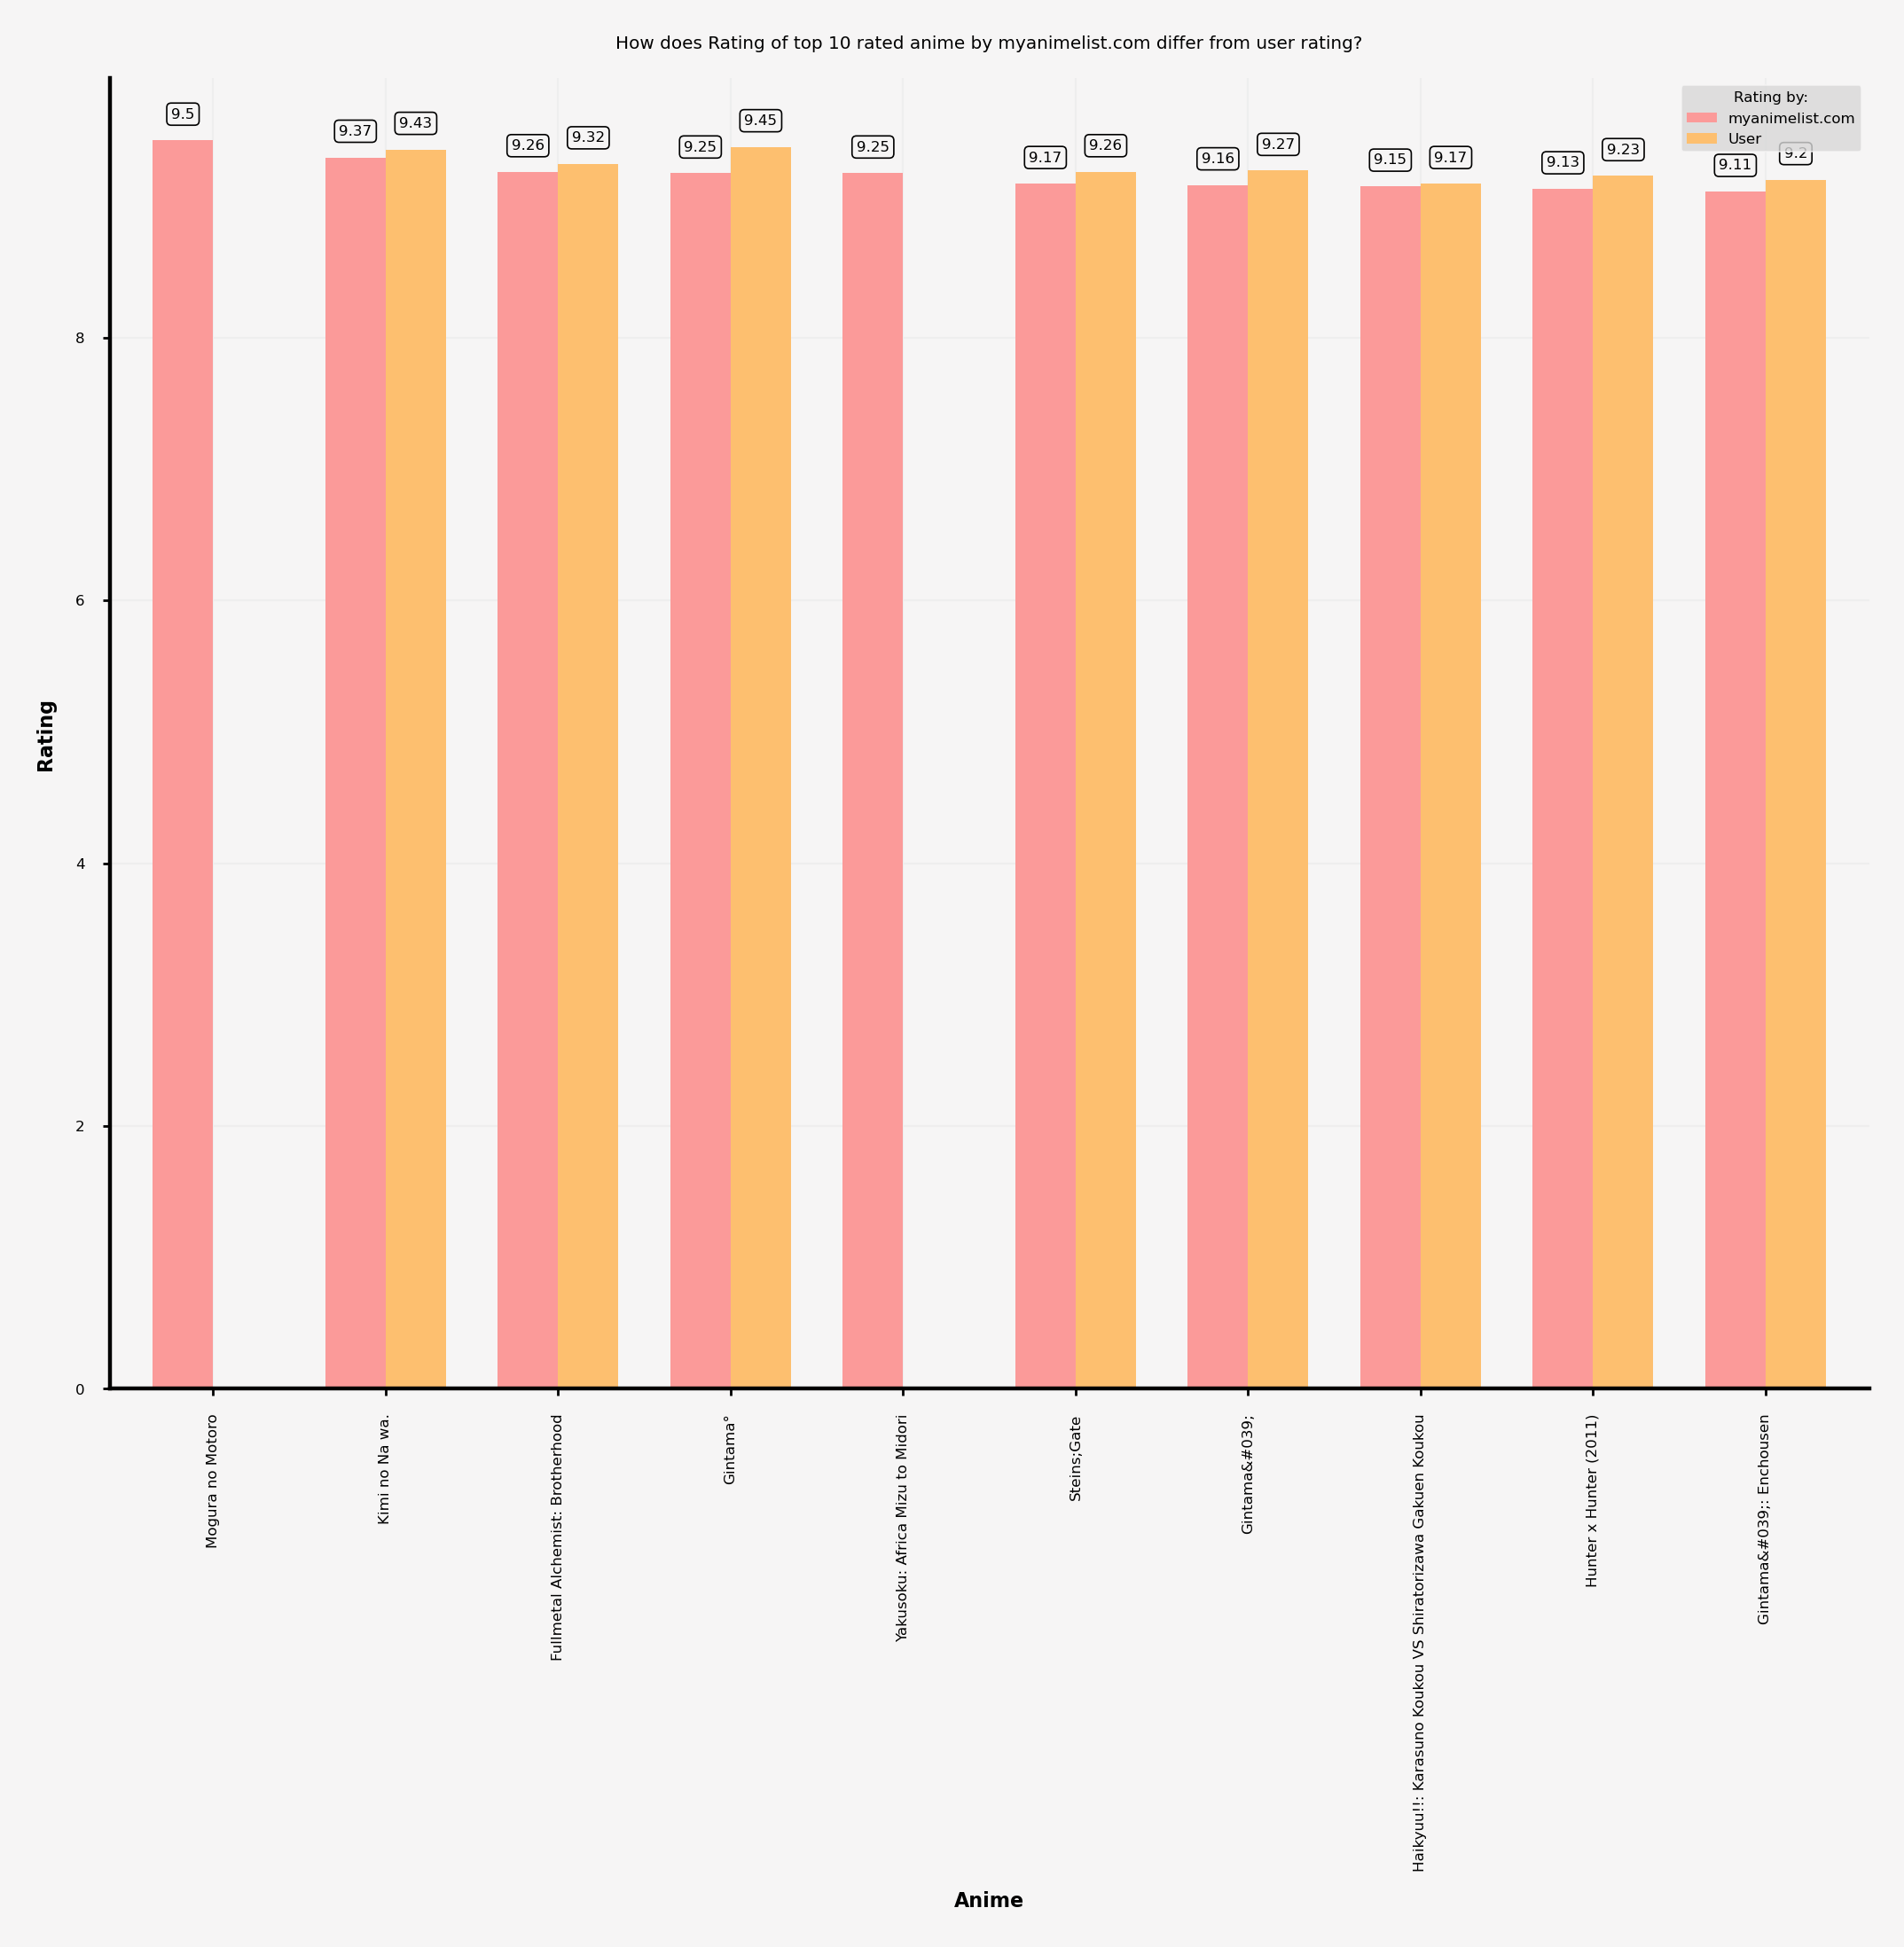

In [160]:
df_tt_rating=df.sort_values("rating", ascending=False).head(10)

fig=plt.figure()
gs= fig.add_gridspec(1,wspace=0, hspace=0.05)
ax0= fig.add_subplot(gs[0,0])
toplot=['rating','user_rating']
x_value= np.arange(len(tt["name"]))
width=0.7
ax0_plt= df_tt_rating.plot(x="name", y= ["rating","user_rating"], zorder=2, width= width, color=chart_colors[-4:], kind= "bar", ax=ax0, label=["myanimelist.com","User"])
plt.title("How does Rating of top 10 rated anime by myanimelist.com differ from mean user rating?")
ax0.set_xlabel('Anime',fontsize=4, weight='bold',)
ax0.set_ylabel('Rating',fontsize=4, weight='bold')
ax0.grid(which='major', zorder=0, axis='x')
ax0.grid(which='major', zorder=0, axis='y')
for p in ax0_plt.patches:
    height= p.get_height()
    width= p.get_width()
    if height == 0:
        pass
    else:
        #find x and y coordinate of ear bar to add labels
        x= p.get_center()[0]
        y= height + 0.2
        label_value= str(height)
        ax0_plt.text(x,y,label_value, ha='center', va="center", bbox= dict(boxstyle='round'))
ax0.legend(title="Rating by:")
plt.show()

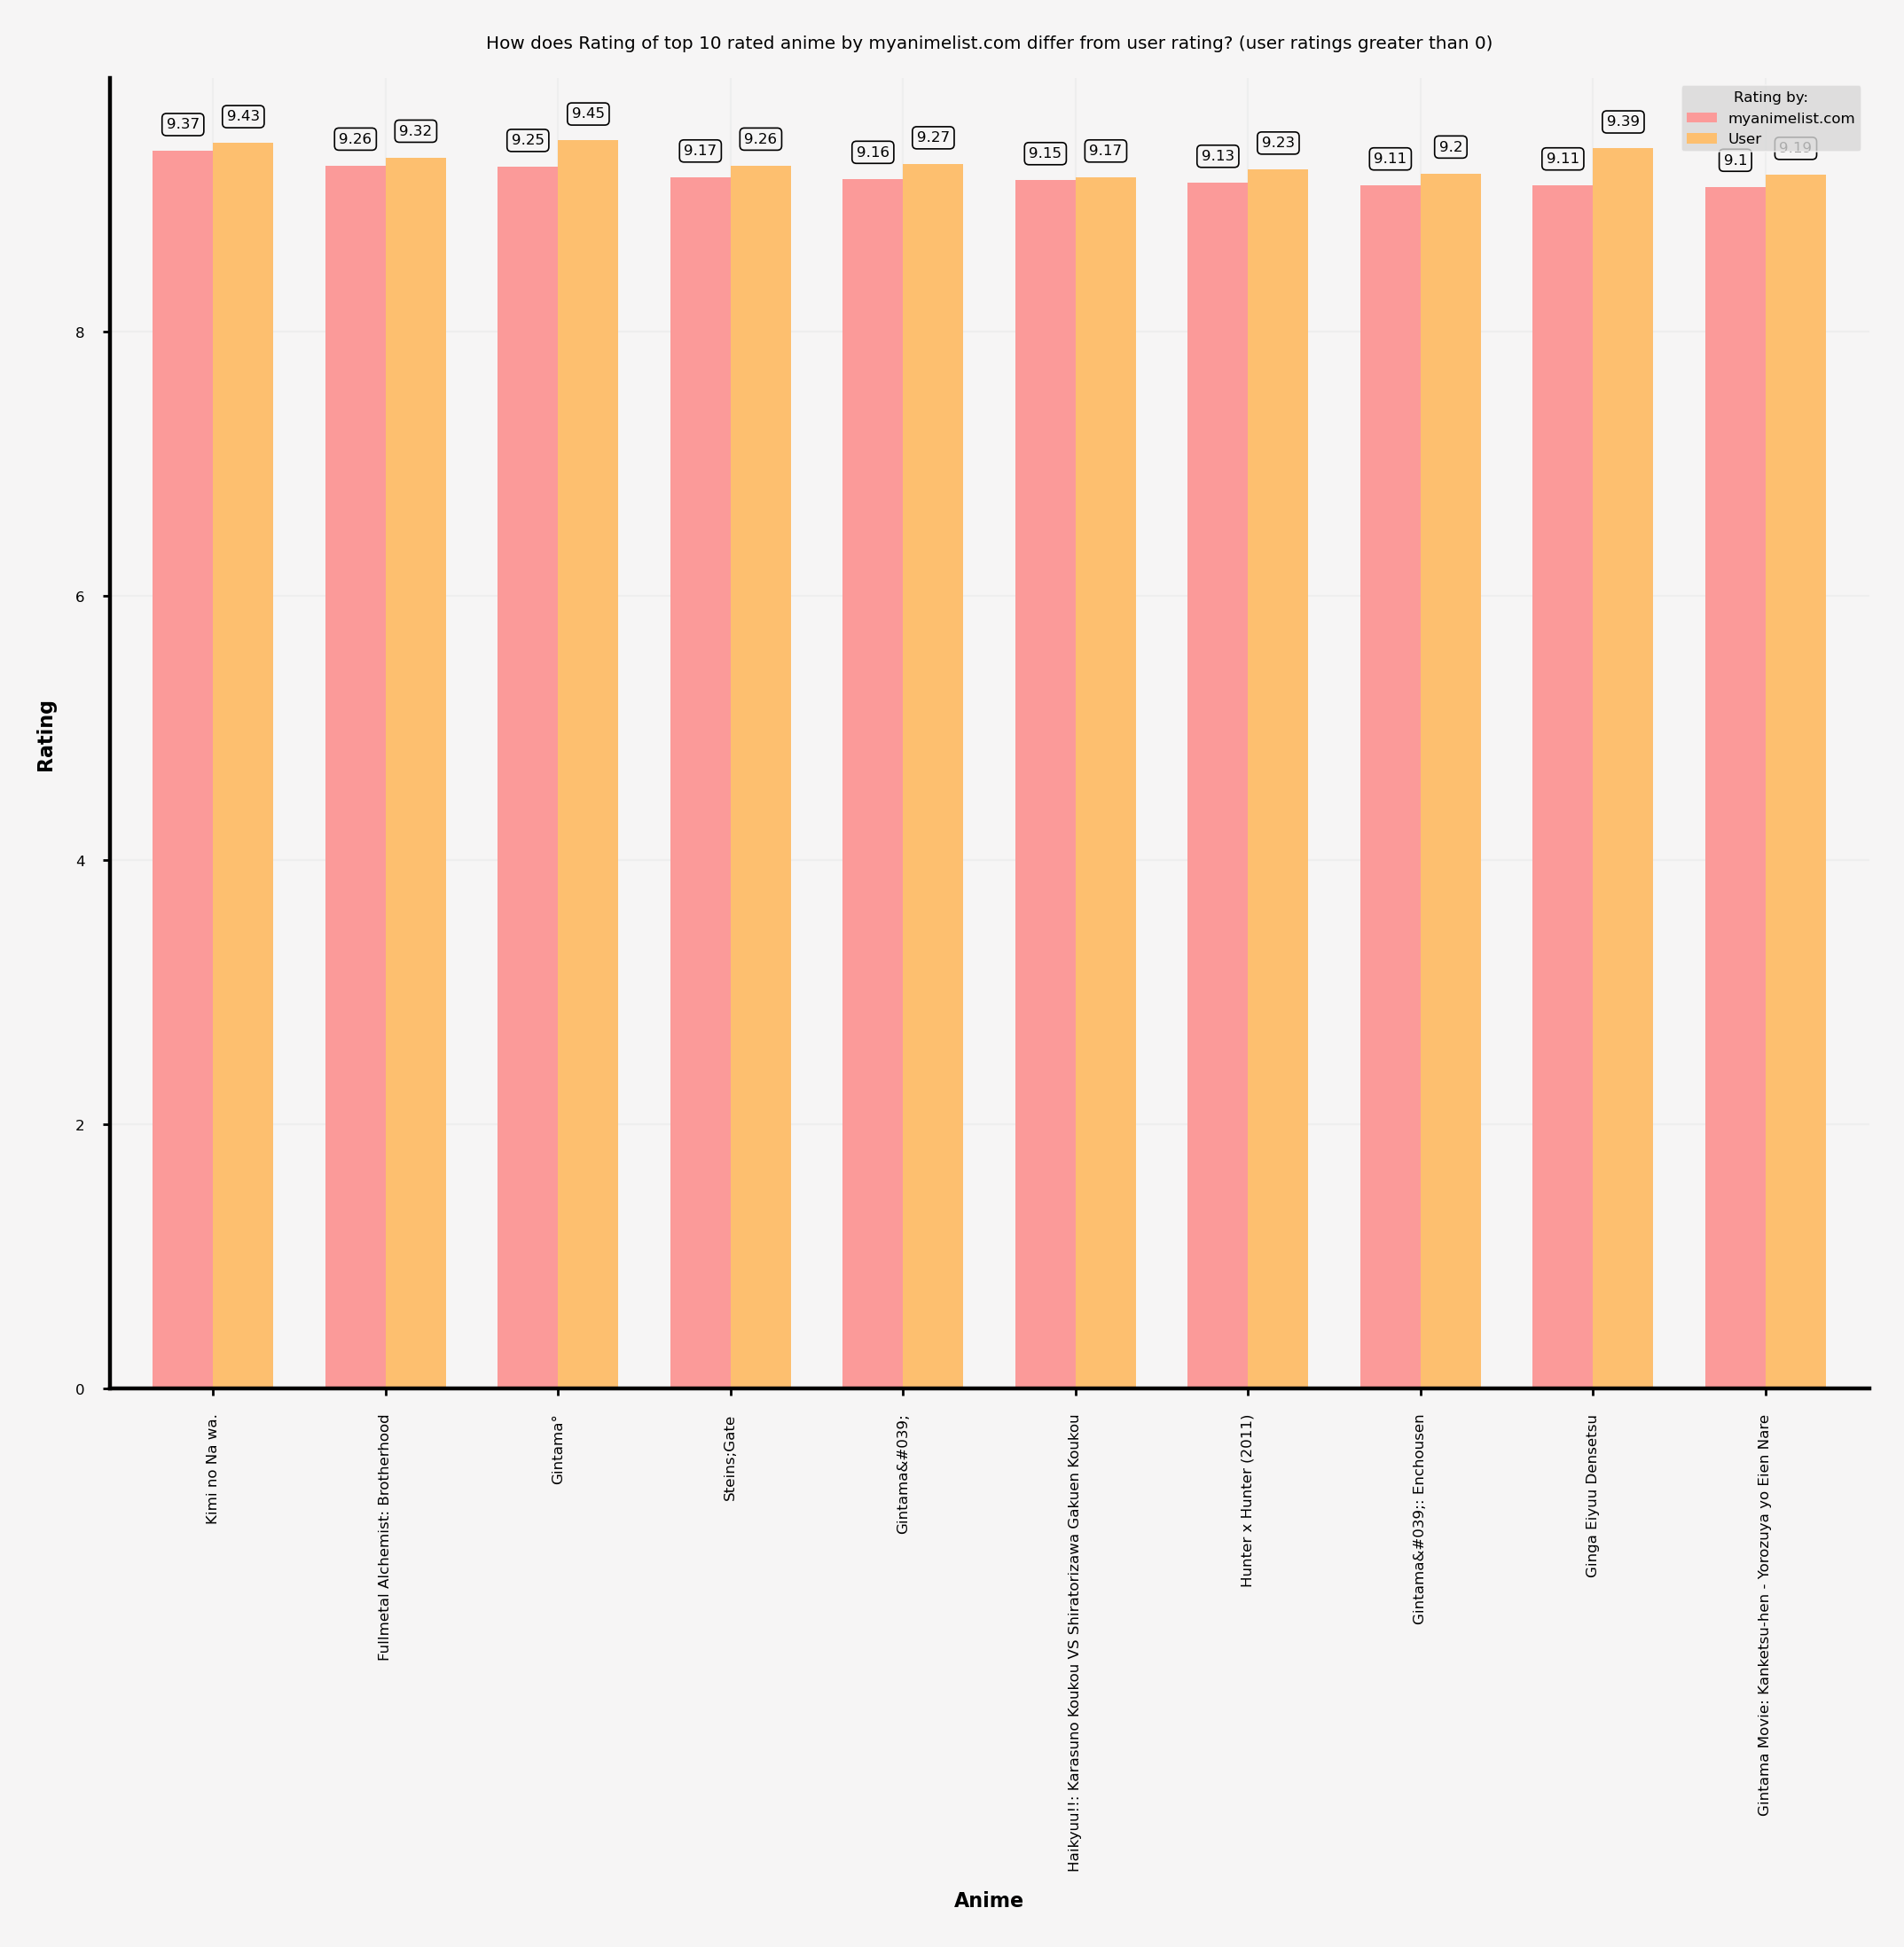

In [238]:
fig=plt.figure()
gs= fig.add_gridspec(1,wspace=0, hspace=0.05)
ax0= fig.add_subplot(gs[0,0])
toplot=['rating','user_rating']
x_value= np.arange(len(tt["name"]))
width=0.7
ax0_plt= tt.plot(x="name", y= ["rating","user_rating"], zorder=2, width= width, color=chart_colors[-4:], kind= "bar", ax=ax0, label=["myanimelist.com","User"])
plt.title("How does Rating of top 10 rated anime by myanimelist.com differ from user rating? (user ratings greater than 0)")
ax0.set_xlabel('Anime',fontsize=4, weight='bold',)
ax0.set_ylabel('Rating',fontsize=4, weight='bold')
ax0.grid(which='major', zorder=0, axis='x')
ax0.grid(which='major', zorder=0, axis='y')
for p in ax0_plt.patches:
    height= p.get_height()
    width= p.get_width()
    if height == 0:
        pass
    else:
        #find x and y coordinate of ear bar to add labels
        x= p.get_center()[0]
        y= height + 0.2
        label_value= str(height)
        ax0_plt.text(x,y,label_value, ha='center', va="center", bbox= dict(boxstyle='round'))
ax0.legend(title="Rating by:")

In [162]:
import seaborn as sns
import matplotlib

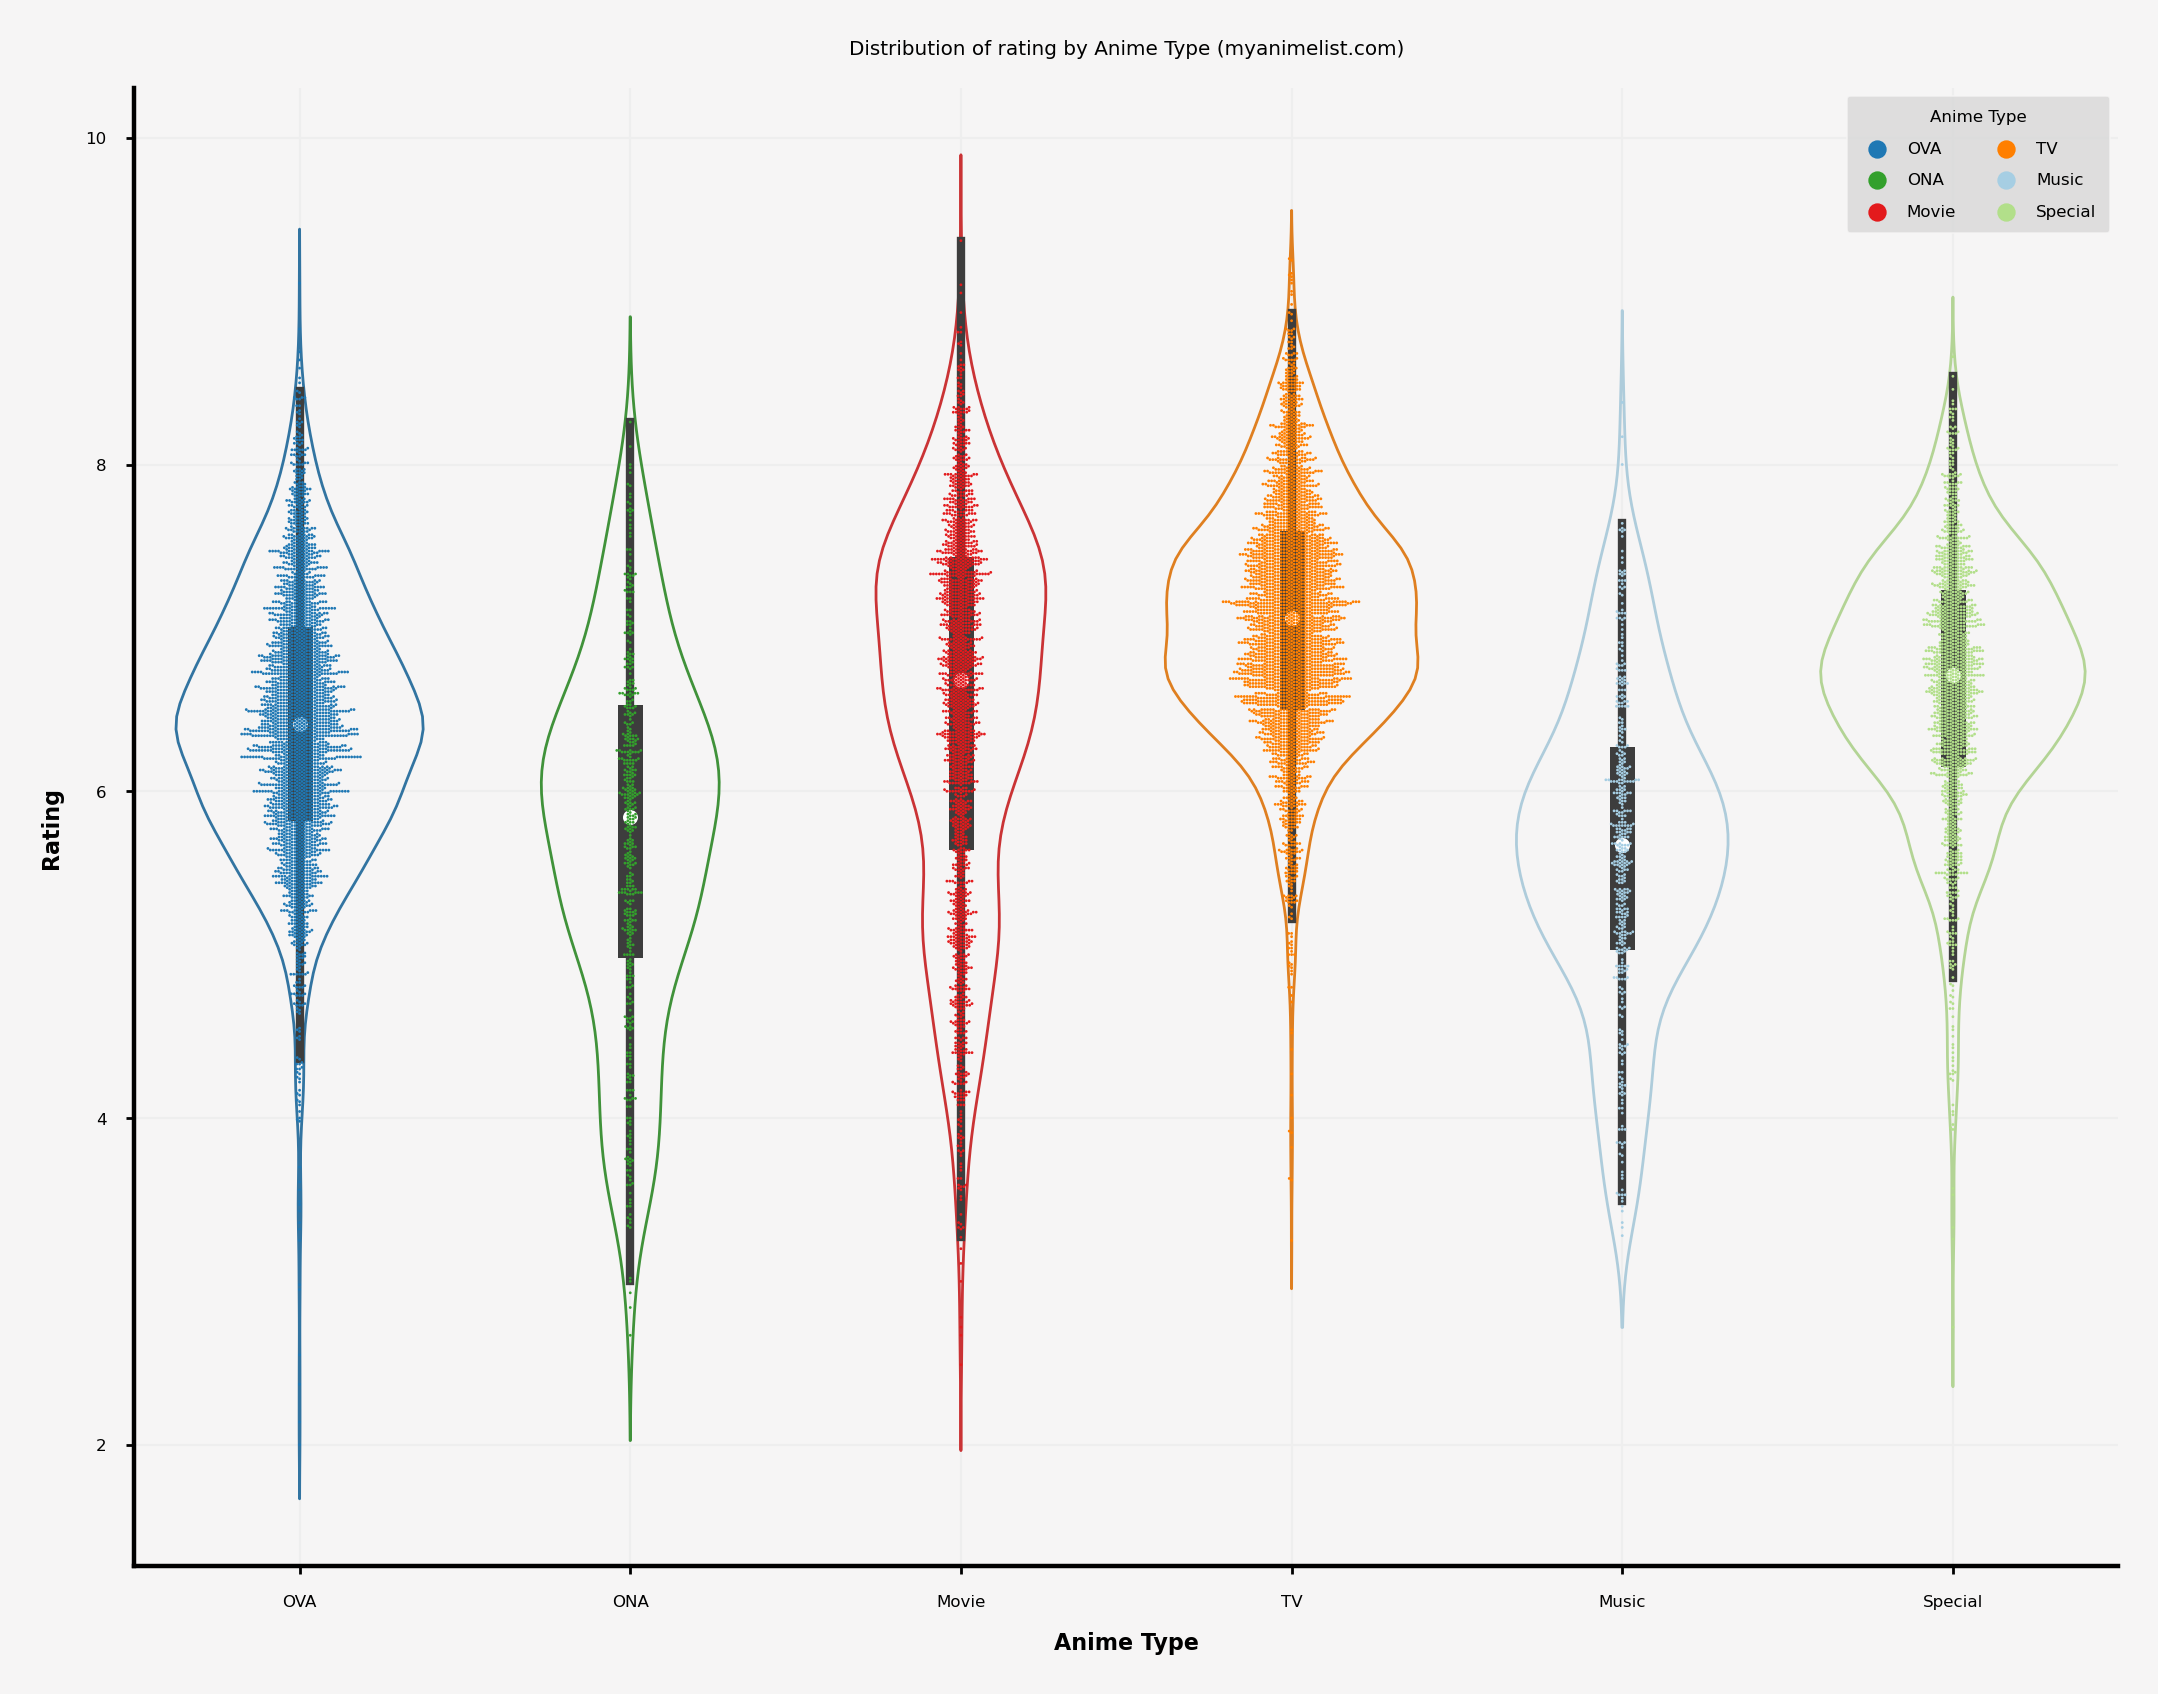

In [163]:
fig= plt.figure()
gs= fig.add_gridspec(1)
gs.update(wspace=0, hspace=0.05)
ax0= fig.add_subplot(gs[0,0])
ax0_plt=sns.swarmplot(x="type",  y="rating", hue="type", data= user_rating_ge0, s=0.5, zorder=4 , palette= exclude_colors[:6])
ax0_viol=sns.violinplot(x="type", y="rating", data= user_rating_ge0,ax=ax0 , palette= exclude_colors)

for collection in ax0_viol.collections:
    if isinstance(collection, matplotlib.collections.PolyCollection):
        collection.set_edgecolor(collection.get_facecolor())
        collection.set_facecolor('none')
        collection.set_linewidth(0.5)
        collection.set_zorder(2)

plt.title("Distribution of rating by Anime Type (myanimelist.com)")
ax0.set_xlabel('Anime Type',fontsize=4, weight='bold',)
ax0.set_ylabel('Rating',fontsize=4, weight='bold')
ax0.grid(which='major', zorder=0, axis='x')
ax0.grid(which='major', zorder=0, axis='y')
ax0_plt.legend(title="Anime Type",ncols=2, borderpad=0.8,markerscale=0.5, labelspacing=1 )
plt.show()

In [164]:
df

,anime_id,name,type,genre,episodes,rating,members,user_rating
4173,5542,Telepathist IQ Saiko,OVA,Hentai,1.0,5.31,252.0,1.0
11144,33861,Nani no Yaku ni Mo Tatanai Karappona Hanashi,ONA,Comedy,2.0,3.50,33.0,1.0
10085,29989,Kaze no Kokyuu: Animation ni Yoru Oufuku Shokan,Movie,Dementia,1.0,4.92,132.0,1.0
10775,32269,Xiyue Qi Tong,Movie,"Action, Adventure, Fantasy",1.0,4.78,45.0,1.0
10202,30326,Ushi Atama,Movie,Dementia,1.0,4.87,120.0,1.0
...,...,...,...,...,...,...,...,...
11182,34173,Buddy Go! 2,Special,"Comedy, Romance, Shoujo",4.0,6.39,304.0,NaN
11191,34358,Ocha-ken: Hotto Monogatari,TV,"Kids, Slice of Life",13.0,6.67,29.0,NaN
11193,34412,Hashiri Hajimeta bakari no Kimi ni,Music,Music,1.0,6.76,239.0,NaN
11195,34476,Platonic Chain: Ansatsu Jikkouchuu,Special,"Sci-Fi, Slice of Life",1.0,1.67,51.0,NaN


In [165]:
user_rating_ge0

,anime_id,name,type,genre,episodes,rating,members,user_rating
4173,5542,Telepathist IQ Saiko,OVA,Hentai,1.0,5.31,252.0,1.0
11144,33861,Nani no Yaku ni Mo Tatanai Karappona Hanashi,ONA,Comedy,2.0,3.50,33.0,1.0
10085,29989,Kaze no Kokyuu: Animation ni Yoru Oufuku Shokan,Movie,Dementia,1.0,4.92,132.0,1.0
10775,32269,Xiyue Qi Tong,Movie,"Action, Adventure, Fantasy",1.0,4.78,45.0,1.0
10202,30326,Ushi Atama,Movie,Dementia,1.0,4.87,120.0,1.0
...,...,...,...,...,...,...,...,...
10190,30289,Dededen,Special,Slice of Life,5.0,5.99,158.0,10.0
4139,5468,Yattokame Tanteidan,TV,"Kids, Mystery, Slice of Life",14.0,6.50,141.0,10.0
6066,10113,Yokohama Meibutsu: Otoko Katayama-gumi!,OVA,"Action, School, Shounen",2.0,6.53,150.0,10.0
7042,13827,Kamiusagi Rope x Panasonic Collaboration,Movie,"Comedy, Slice of Life",1.0,5.79,116.0,10.0


In [166]:
# fig= plt.figure()
# gs= fig.add_gridspec(1)
# gs.update(wspace=0, hspace=0.05)
# ax0= fig.add_subplot(gs[0,0])
# ax0_plt=user_rating_ge0.plot('rating', "user_rating" ,zorder=2,kind='scatter', color='black' ,ax= ax0, s=0.5)

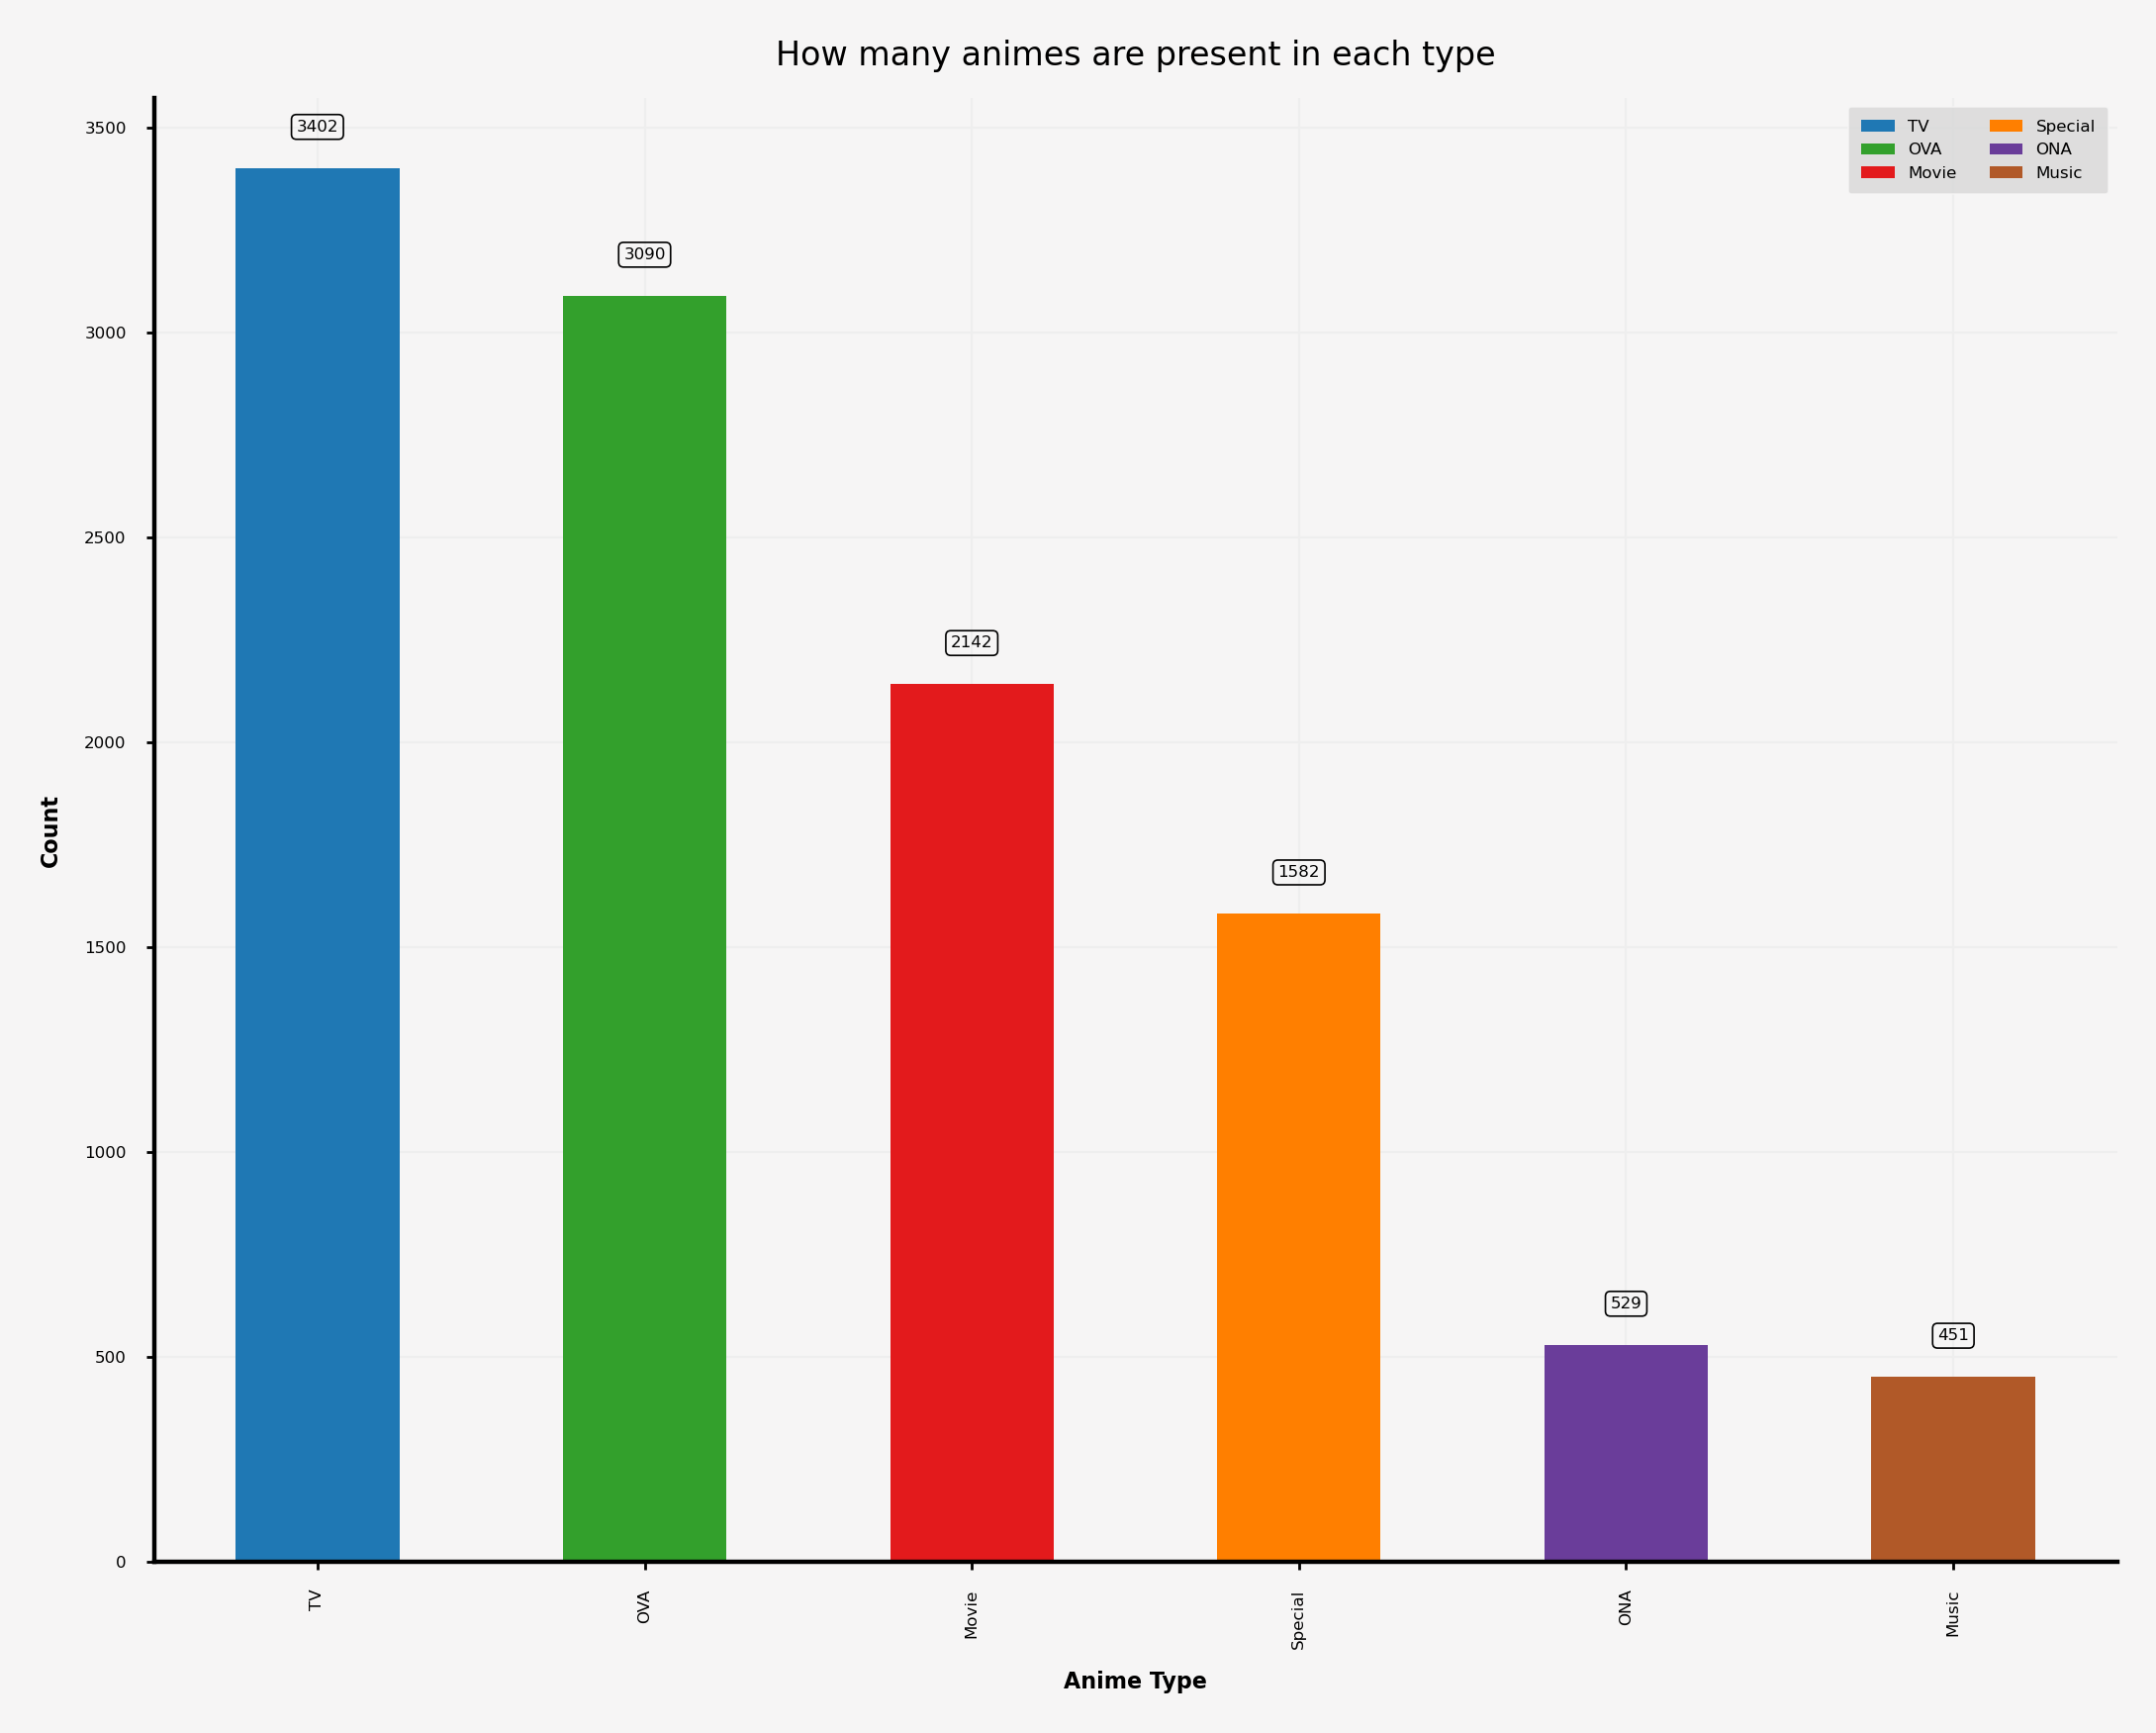

In [167]:
fig= plt.figure()
gs= fig.add_gridspec(1)
gs.update(wspace=0, hspace=0.05)
ax0= fig.add_subplot(gs[0,0])
ax0_plt=anime_type.plot(x='anime_type', y="anime_count", color=chart_colors ,zorder=2,kind='bar', ax= ax0)
ax0.set_xlabel('Anime Type',fontsize=4, weight='bold',)
ax0.set_ylabel('Count',fontsize=4, weight='bold')
ax0.grid(which='major', zorder=0, axis='x')
ax0.grid(which='major', zorder=0, axis='y')



plt.title("How many animes are present in each type", fontsize=6)
for p in ax0_plt.patches:
    height= p.get_height()
    width= p.get_width()
    if height == 0:
        pass
    else:
        #find x and y coordinate of ear bar to add labels
        x= p.get_center()[0]
        y= height + 100
        label_value= str(height)
        ax0_plt.text(x,y,label_value, ha='center', va="center", bbox= dict(boxstyle='round'))
        
# ax0_plt.legend(anime_type['anime_count'], list(anime_type["anime_type"].values))
ax0_plt.legend(handles=[p for p in ax0_plt.patches] , labels=list(anime_type["anime_type"].values),ncols=2, borderpad=0.8)
# plt.legend('',frameon=False)
plt.show()

In [168]:
list(anime_type["anime_type"].values)

['TV', 'OVA', 'Movie', 'Special', 'ONA', 'Music']

In [169]:
anime_df['episodes'].nunique()

183

In [170]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7813720 entries, 0 to 7813719
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   anime_id     int64  
 1   name         object 
 2   genre        object 
 3   type         object 
 4   episodes     float64
 5   rating       float64
 6   members      int64  
 7   user_id      int64  
 8   user_rating  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 596.1+ MB


In [171]:
df

,anime_id,name,type,genre,episodes,rating,members,user_rating
4173,5542,Telepathist IQ Saiko,OVA,Hentai,1.0,5.31,252.0,1.0
11144,33861,Nani no Yaku ni Mo Tatanai Karappona Hanashi,ONA,Comedy,2.0,3.50,33.0,1.0
10085,29989,Kaze no Kokyuu: Animation ni Yoru Oufuku Shokan,Movie,Dementia,1.0,4.92,132.0,1.0
10775,32269,Xiyue Qi Tong,Movie,"Action, Adventure, Fantasy",1.0,4.78,45.0,1.0
10202,30326,Ushi Atama,Movie,Dementia,1.0,4.87,120.0,1.0
...,...,...,...,...,...,...,...,...
11182,34173,Buddy Go! 2,Special,"Comedy, Romance, Shoujo",4.0,6.39,304.0,NaN
11191,34358,Ocha-ken: Hotto Monogatari,TV,"Kids, Slice of Life",13.0,6.67,29.0,NaN
11193,34412,Hashiri Hajimeta bakari no Kimi ni,Music,Music,1.0,6.76,239.0,NaN
11195,34476,Platonic Chain: Ansatsu Jikkouchuu,Special,"Sci-Fi, Slice of Life",1.0,1.67,51.0,NaN


In [172]:
# top 10 anime by number of episodes
# anime_df['episodes'] = pd.to_numeric(anime_df['episodes'], errors='coerce').fillna(0).astype("int")
top_10_animes_byepisodes=df[["name","episodes"]].sort_values("episodes", ascending=False).head(10)

In [173]:
top_10_animes_byepisodes

,name,episodes
6736,Oyako Club,1818.0
2261,Doraemon (1979),1787.0
8888,Kirin Monoshiri Yakata,1565.0
4530,Manga Nippon Mukashibanashi (1976),1471.0
5275,Hoka Hoka Kazoku,1428.0
8609,Monoshiri Daigaku: Ashita no Calendar,1274.0
6117,Sekai Monoshiri Ryoko,1006.0
8217,Kotowaza House,773.0
5885,Shima Shima Tora no Shimajirou,726.0
3885,Ninja Hattori-kun,694.0


In [174]:
anime_rating= df[["rating","name"]]
anime_rating.dropna(inplace=True)
top_10_animes_byrating=anime_rating.sort_values("rating", ascending=False).head(10)
worst_10_animes_byrating=anime_rating.sort_values("rating", ascending=True).head(10)

C:\Users\sanka\AppData\Local\Temp\ipykernel_5700\2056213205.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_rating.dropna(inplace=True)


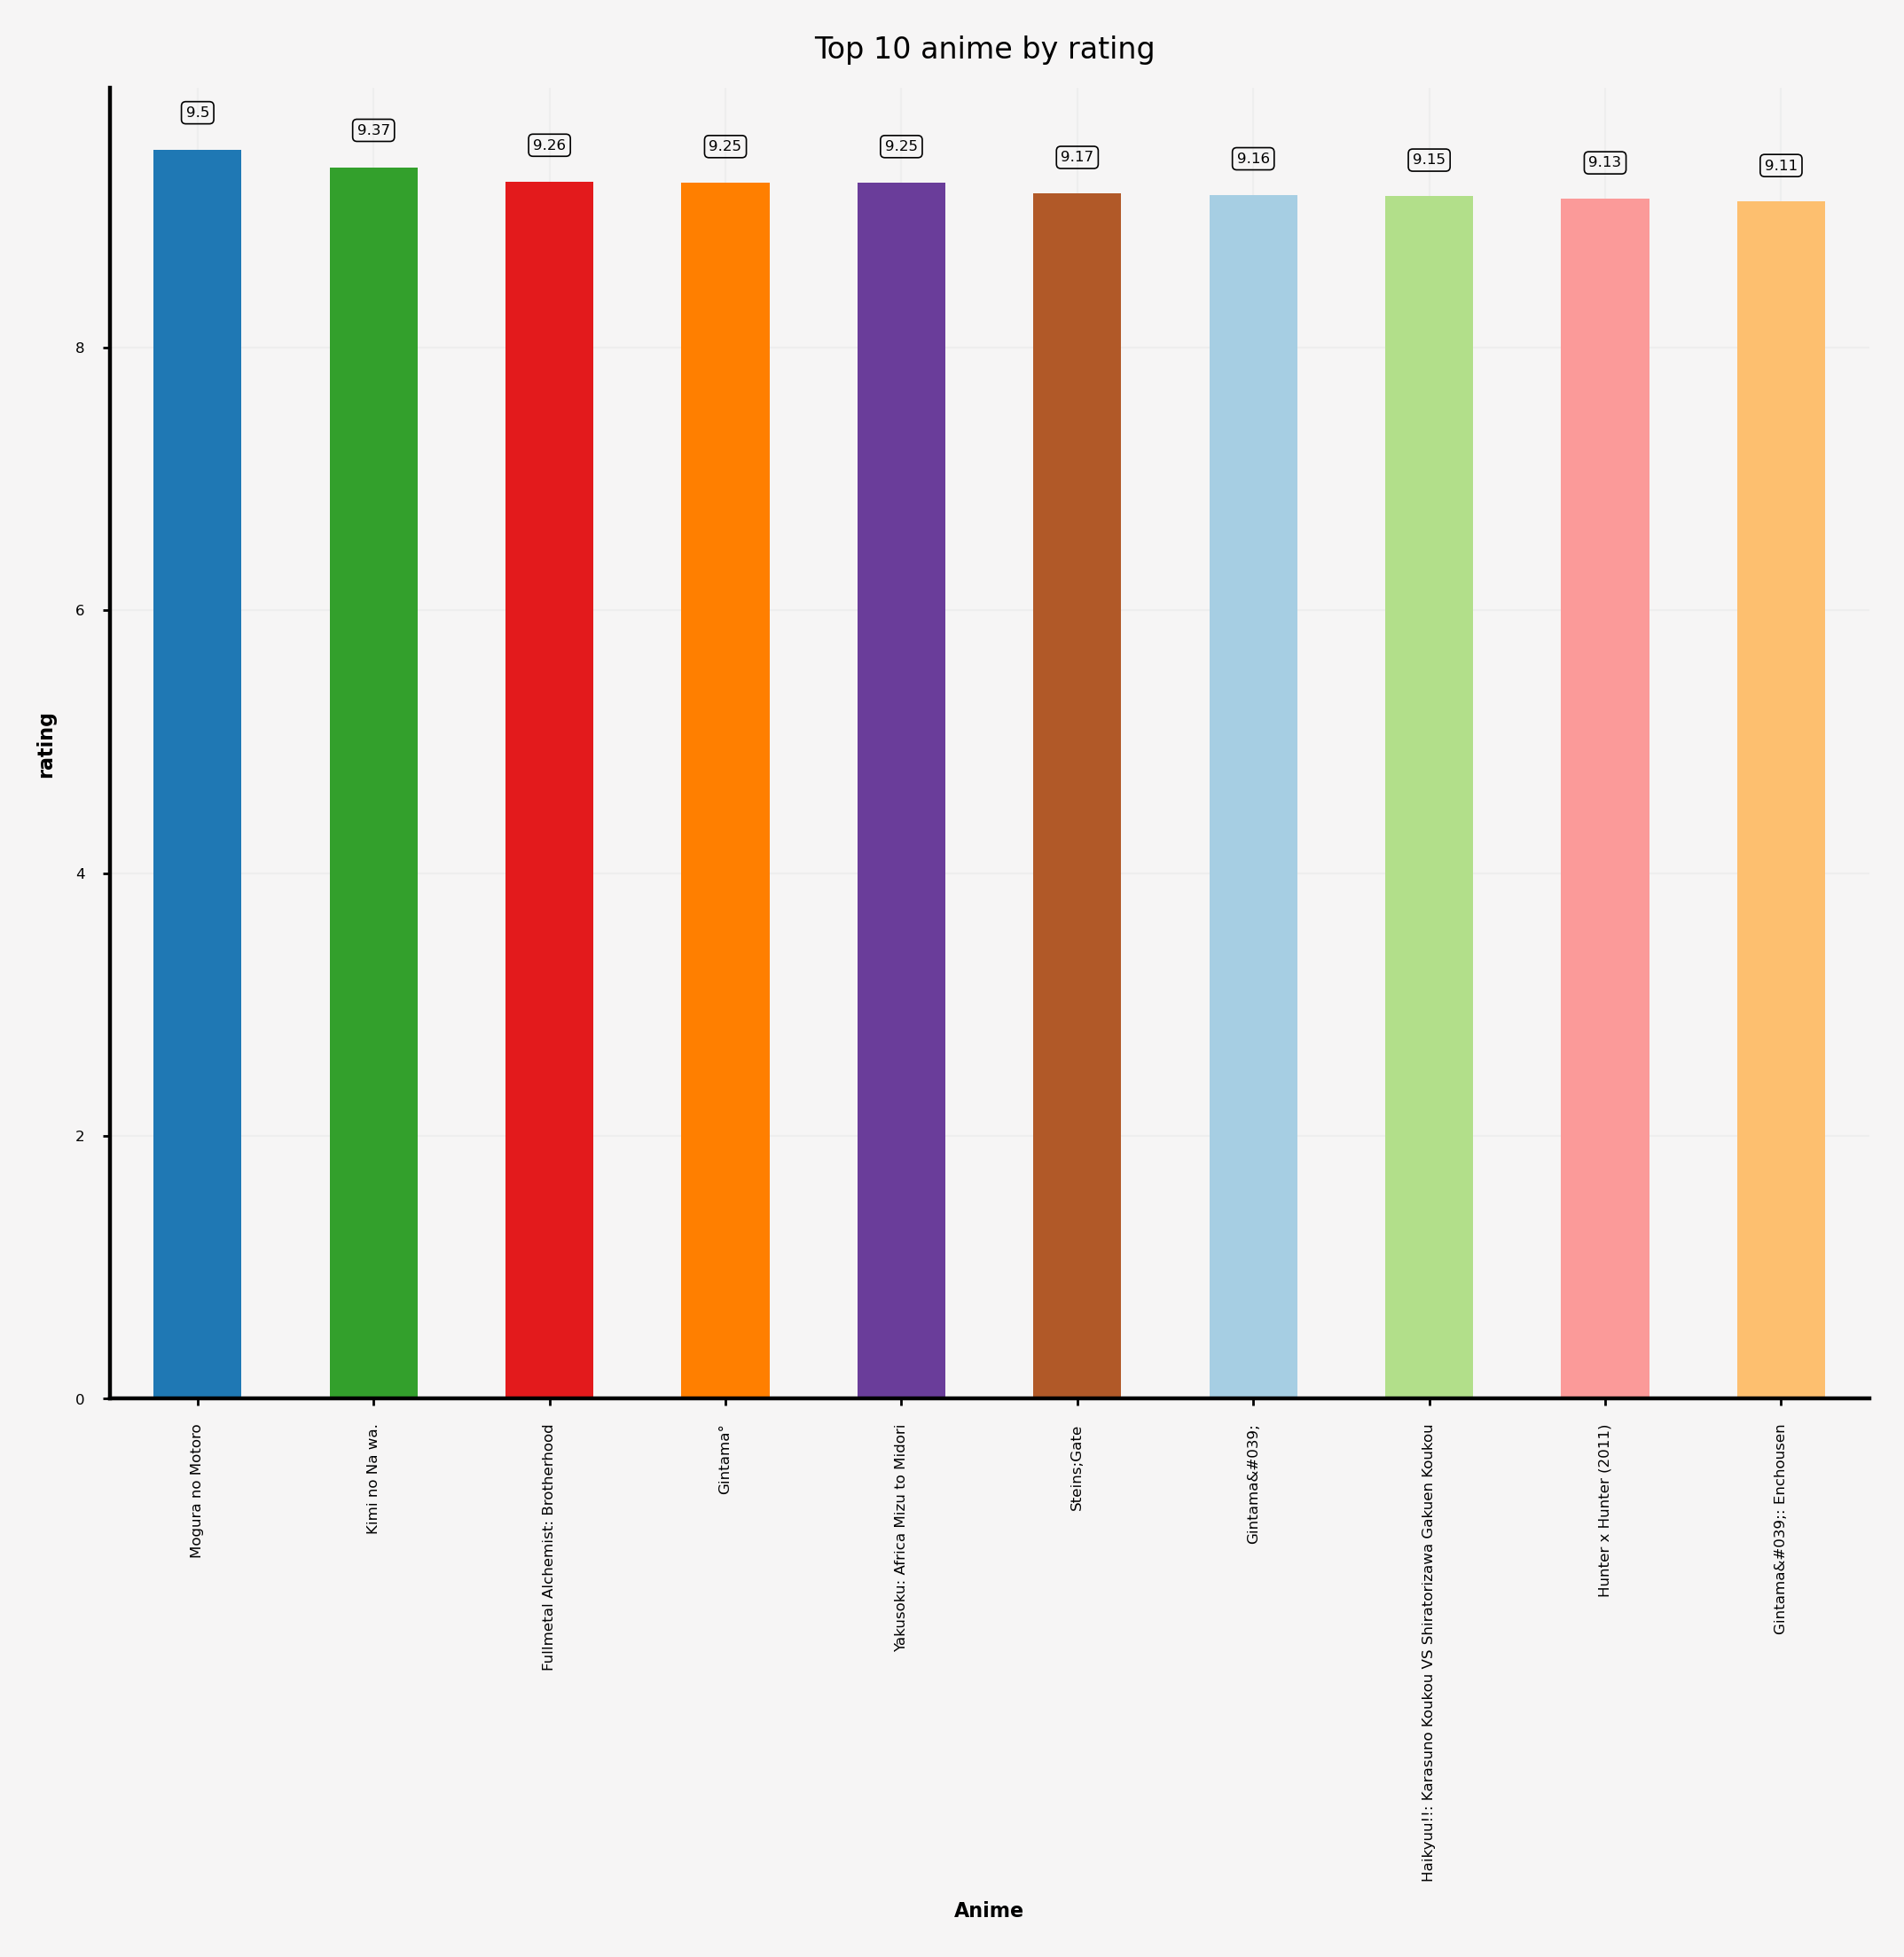

In [175]:
fig= plt.figure()
gs= fig.add_gridspec(1,1)
gs.update(wspace=0, hspace=0.05)
ax0= fig.add_subplot(gs[0,0])

ax0_plt=top_10_animes_byrating.plot(x='name', y="rating", color=chart_colors ,zorder=2,kind='bar', ax= ax0)
ax0.set_xlabel('Anime',fontsize=4, weight='bold',)
ax0.set_ylabel('rating',fontsize=4, weight='bold')
ax0.grid(which='major', zorder=0, axis='x')
ax0.grid(which='major', zorder=0, axis='y')


plt.title("Top 10 anime by rating ", fontsize=6)
for p in ax0_plt.patches:
    height= p.get_height()
    width= p.get_width()
    if height == 0:
        pass
    else:
        #find x and y coordinate of ear bar to add labels
        x= p.get_center()[0]
        # x= p.get_x()
        y= height + 0.03*height
        label_value= str(height)
        ax0_plt.text(x,y,label_value, ha='center', va="center", bbox= dict(boxstyle='round'))
        
plt.legend('',frameon=False)

plt.show()

In [176]:
anime_df['rating'] = pd.to_numeric(anime_df['rating'], errors='coerce').dropna().astype("float")

Oyako Club
Doraemon (1979)
Kirin Monoshiri Yakata
Manga Nippon Mukashibanashi (1976)
Hoka Hoka Kazoku
Monoshiri Daigaku: Ashita no Calendar
Sekai Monoshiri Ryoko
Kotowaza House
Shima Shima Tora no Shimajirou
Ninja Hattori-kun


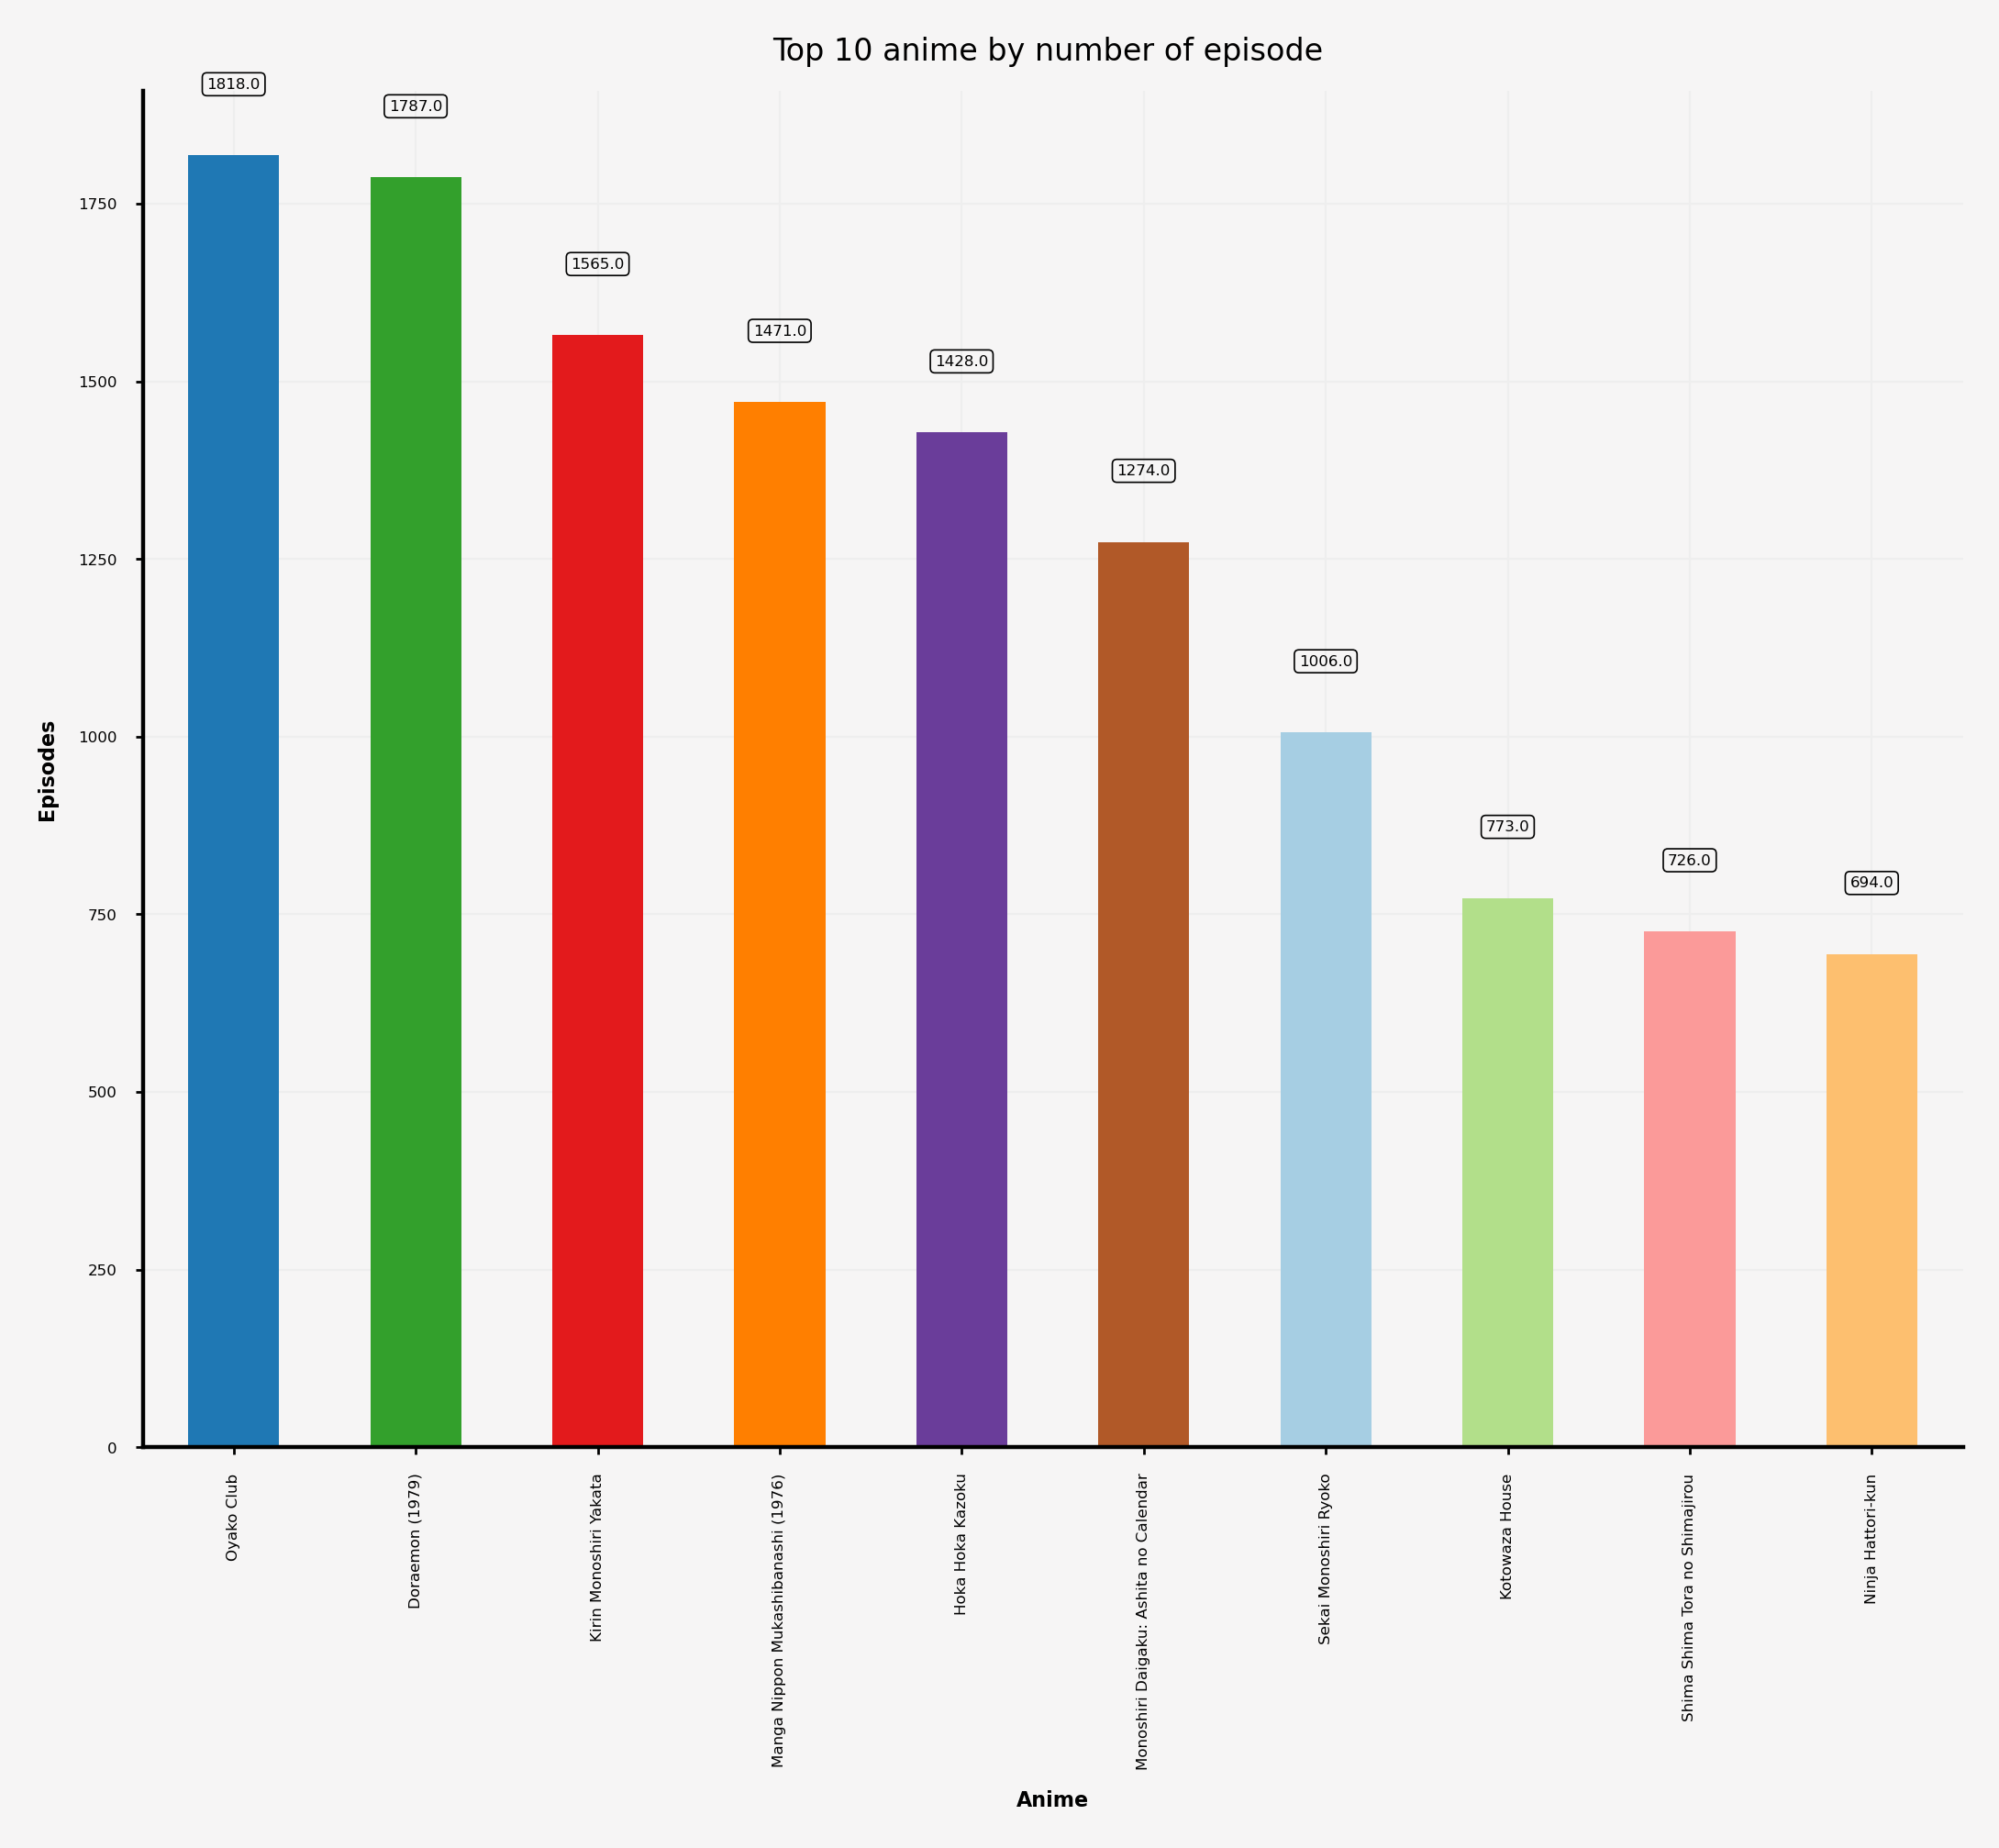

In [177]:
fig= plt.figure()
gs= fig.add_gridspec(1,1)
gs.update(wspace=0, hspace=0.05)
ax0= fig.add_subplot(gs[0,0])

ax0_plt=top_10_animes_byepisodes.plot(x='name', y="episodes", color=chart_colors ,zorder=2,kind='bar', ax= ax0)
for i in top_10_animes_byepisodes["name"].values:
    print(i)
    # top_10_animes_byepisodes.boxplot(x=i)
ax0.set_xlabel('Anime',fontsize=4, weight='bold',)
ax0.set_ylabel('Episodes',fontsize=4, weight='bold')
ax0.grid(which='major', zorder=0, axis='x')
ax0.grid(which='major', zorder=0, axis='y')


plt.title("Top 10 anime by number of episode ", fontsize=6)
for p in ax0_plt.patches:
    height= p.get_height()
    width= p.get_width()
    if height == 0:
        pass
    else:
        #find x and y coordinate of ear bar to add labels
        x= p.get_center()[0]
        # x= p.get_x()
        y= height + 100
        label_value= str(height)
        ax0_plt.text(x,y,label_value, ha='center', va="center", bbox= dict(boxstyle='round'))
        
plt.legend('',frameon=False)

plt.show()

In [178]:
for p in ax0_plt.patches:
    print("patches:",p)
    print("get_angle:", p.get_angle())
    print("get_bbox() :",p.get_bbox())
    print("get_center:", p.get_center(),"\n")
    print("get_corners:", p.get_corners())#corner on anticlockwise direction
    print("get_height:", p.get_height())
    print("get_path:", p.get_path())
    print("get_width:", p.get_width())
    print("get_xy:", p.get_xy())
    print("get_x() :", p.get_x())
    print("get_y() :",p.get_y())
    print("rotation_point :",p.rotation_point)
    print("get_facecolor() :",p.get_facecolor())
    print('---'*20)

patches: Rectangle(xy=(-0.25, 0), width=0.5, height=1818, angle=0)
get_angle: 0.0
get_bbox() : Bbox(x0=-0.25, y0=0.0, x1=0.25, y1=1818.0)
get_center: [  0. 909.] 

get_corners: [[-2.500e-01  0.000e+00]
 [ 2.500e-01  0.000e+00]
 [ 2.500e-01  1.818e+03]
 [-2.500e-01  1.818e+03]]
get_height: 1818.0
get_path: Path(array([[0., 0.],
       [1., 0.],
       [1., 1.],
       [0., 1.],
       [0., 0.]]), array([ 1,  2,  2,  2, 79], dtype=uint8))
get_width: 0.5
get_xy: (-0.25, 0)
get_x() : -0.25
get_y() : 0
rotation_point : xy
get_facecolor() : (0.12156862745098039, 0.47058823529411764, 0.7058823529411765, 1.0)
------------------------------------------------------------
patches: Rectangle(xy=(0.75, 0), width=0.5, height=1787, angle=0)
get_angle: 0.0
get_bbox() : Bbox(x0=0.75, y0=0.0, x1=1.25, y1=1787.0)
get_center: [  1.  893.5] 

get_corners: [[7.500e-01 0.000e+00]
 [1.250e+00 0.000e+00]
 [1.250e+00 1.787e+03]
 [7.500e-01 1.787e+03]]
get_height: 1787.0
get_path: Path(array([[0., 0.],
       [1

In [179]:
# plt.rcParams["patch.facecolor"]='none'
# plt.rcParams["patch.linewidth"]=0.3
# plt.rcParams["font.size"]=3